In [95]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from math import log
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [102]:
# Path for the proteinGroups file
pg_path = 'C:/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Projects/Puram_Samples/TimsTOF_All/NoFraction_CorrectNaming/proteinGroups.txt'

# Comment out if not on windows
pg_path = pg_path.replace('/','\\')

pg = pd.read_csv(pg_path,delimiter='\t')
pg

C:\Users\plutzer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (168,169) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Taxonomy IDs
0,P0DPI2;A0A0B4J2D5;P0DPI2-2;A0A0B4J2D5-2,P0DPI2;A0A0B4J2D5;P0DPI2-2;A0A0B4J2D5-2,9;9;7;7,9;9;7;7,9;9;7;7,NaN,NaN,sp|P0DPI2|GAL3A_HUMAN Glutamine amidotransfera...,4,9,...,0,13344;17573;22069;24664;24665;30840;46236;4752...,True;True;True;True;True;True;True;True;True,13900;18302;23011;25719;25720;32187;48521;4988...,264962;264963;264964;264965;264966;264967;2649...,153316;153317;153318;153319;153320;153321;1533...,153323;197830;251753;281145;281161;354137;5268...,NaN,NaN,-1;-1;-1;-1
1,A0A0U1RRE5,A0A0U1RRE5,2,2,2,NaN,NaN,sp|A0A0U1RRE5|NBDY_HUMAN Negative regulator of...,1,2,...,1,52695;70300,True;True,55246;73653,1045830;1045831;1045832;1045833;1045834;104583...,595422;595423;595424;595425;595426;595427;7965...,595426;796577,NaN,NaN,-1
2,A0A0U1RRL7,A0A0U1RRL7,2,2,2,NaN,NaN,sp|A0A0U1RRL7|MMPOS_HUMAN Protein MMP24OS OS=H...,1,2,...,2,21083;26375,True;True,21991;27494,415878;415879;415880;415881;415882;415883;4158...,240266;240267;240268;240269;240270;240271;2402...,240268;300731,NaN,NaN,-1
3,A0AV96-2;A0AV96,A0AV96-2;A0AV96,1;1,1;1,1;1,RNA-binding protein 47,RBM47,sp|A0AV96-2|RBM47_HUMAN Isoform 2 of RNA-bindi...,2,1,...,3,60393,True,63271,1194964;1194965;1194966;1194967;1194968;119496...,675954;675955;675956;675957;675958;675959;6759...,675962,NaN,NaN,-1;-1
4,A0AVT1;A0AVT1-2;A0AVT1-3;A0AVT1-4,A0AVT1;A0AVT1-2,50;33;14;12,50;33;14;12,50;33;14;12,Ubiquitin-like modifier-activating enzyme 6,UBA6,sp|A0AVT1|UBA6_HUMAN Ubiquitin-like modifier-a...,4,50,...,4,831;3556;6859;6939;7208;8064;8819;9366;9367;12...,True;True;True;True;True;True;True;True;True;T...,869;3726;7169;7251;7530;8415;9203;9767;9768;13...,16576;16577;16578;16579;16580;16581;16582;1658...,10125;10126;10127;10128;10129;10130;10131;1013...,10125;43045;82240;82943;85811;94769;103020;108...,0;1,1;162,-1;-1;-1;-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6051,REV__Q9Y216-2;REV__Q9Y216,REV__Q9Y216-2;REV__Q9Y216,1;1,1;1,1;1,NaN,NaN,sp|Q9Y216-2|MTMR7_HUMAN Isoform 2 of Myotubula...,2,1,...,6051,369,True,386,7091;7092;7093;7094;7095;7096;7097,4347,4347,NaN,NaN,-1;-1
6052,REV__Q9Y4A5;REV__Q9Y4A5-2,REV__Q9Y4A5;REV__Q9Y4A5-2,3;2,3;2,3;2,NaN,NaN,sp|Q9Y4A5|TRRAP_HUMAN Transformation/transcrip...,2,3,...,6052,29610;45363;52308,True;True;True,30859;47609;54851,590209;590210;590211;590212;590213;590214;5902...,339524;339525;517538;591713;591714;591715;5917...,339525;517538;591713,NaN,NaN,-1;-1
6053,REV__Q9Y4D1-3;REV__Q9Y4D1-2;REV__Q9Y4D1;REV__Q...,REV__Q9Y4D1-3;REV__Q9Y4D1-2;REV__Q9Y4D1;REV__Q...,2;2;2;1;1,2;2;2;1;1,2;2;2;1;1,NaN,NaN,sp|Q9Y4D1-3|DAAM1_HUMAN Isoform 3 of Dishevele...,5,2,...,6053,19366;52148,True;True,20168;54688,379660;379661;379662;379663;379664;379665;3796...,219039;590177,219039;590177,3023,156,-1;-1;-1;-1;-1
6054,REV__Q9Y586,REV__Q9Y586,1,1,1,NaN,NaN,sp|Q9Y586|MB212_HUMAN Protein mab-21-like 2 OS...,1,1,...,6054,38752,True,40412,772161;772162;772163;772164;772165;772166;7721...,440924;440925;440926;440927;440928;440929;4409...,440930,NaN,NaN,-1


In [103]:
experiments = [
    ['1A','1B','1C'],
    ['2A','2B','2C'],
    ['3A','3B','3C'],
    ['4A','4B','4C'],
    ['5A','5B','5C'],
    ['6A','6B','6C']
]

# experiments = [
#     ['1A'],
#     ['2A'],
#     ['3A']
# ]

In [104]:
# Remove contaminants
pg = pg[pg['Potential contaminant'] != '+']

In [105]:
# Remove decoys
pg = pg[pg['Reverse'] != '+']

In [106]:
# Remove protein groups identified by only one peptide
pg = pg[pg['Peptides'] > 1]

In [107]:
# Remove protein groups that are not identified in at least 2 replicates of the same sample for any condition

# def same_rep_filter(row,experiments):
#     '''
#         Returns True if the protein group for this row has intensity in at least 2 replicates of the same sample for any condition
#     '''
#     for experiment in experiments:
#         count = 0
#         for sample in experiment:
#             if row['LFQ intensity ' + sample] > 0:
#                 count += 1
#         if count >= 2:
#             return True
#     return False

# pg = pg[pg.apply(same_rep_filter,axis=1,args=([experiments]))]

# pg

# Remove protein groups that are not identified in all samples

def all_samples_filter(row,experiments):
    '''
        Returns True if the protein group for this row has nonzero intensity in all replicates of all samples.
    '''
    count = 0
    for experiment in experiments:
        for sample in experiment:
            if row['LFQ intensity ' + sample] > 0:
                count += 0
            else:
                count += 1
    if count >= 1:
        return False
    else:
        return True
    
pg = pg[pg.apply(all_samples_filter,axis=1,args=([experiments]))]

pg

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Taxonomy IDs
0,P0DPI2;A0A0B4J2D5;P0DPI2-2;A0A0B4J2D5-2,P0DPI2;A0A0B4J2D5;P0DPI2-2;A0A0B4J2D5-2,9;9;7;7,9;9;7;7,9;9;7;7,NaN,NaN,sp|P0DPI2|GAL3A_HUMAN Glutamine amidotransfera...,4,9,...,0,13344;17573;22069;24664;24665;30840;46236;4752...,True;True;True;True;True;True;True;True;True,13900;18302;23011;25719;25720;32187;48521;4988...,264962;264963;264964;264965;264966;264967;2649...,153316;153317;153318;153319;153320;153321;1533...,153323;197830;251753;281145;281161;354137;5268...,NaN,NaN,-1;-1;-1;-1
4,A0AVT1;A0AVT1-2;A0AVT1-3;A0AVT1-4,A0AVT1;A0AVT1-2,50;33;14;12,50;33;14;12,50;33;14;12,Ubiquitin-like modifier-activating enzyme 6,UBA6,sp|A0AVT1|UBA6_HUMAN Ubiquitin-like modifier-a...,4,50,...,4,831;3556;6859;6939;7208;8064;8819;9366;9367;12...,True;True;True;True;True;True;True;True;True;T...,869;3726;7169;7251;7530;8415;9203;9767;9768;13...,16576;16577;16578;16579;16580;16581;16582;1658...,10125;10126;10127;10128;10129;10130;10131;1013...,10125;43045;82240;82943;85811;94769;103020;108...,0;1,1;162,-1;-1;-1;-1
5,A0FGR8-2;A0FGR8;A0FGR8-6;A0FGR8-4;A0FGR8-5,A0FGR8-2;A0FGR8;A0FGR8-6;A0FGR8-4,15;15;15;9;6,15;15;15;9;6,15;15;15;9;6,Extended synaptotagmin-2,ESYT2,sp|A0FGR8-2|ESYT2_HUMAN Isoform 2 of Extended ...,5,15,...,5,802;2988;15926;19930;21079;28531;31055;35552;3...,True;True;True;True;True;True;True;True;True;T...,838;3135;16599;20773;21987;29727;32407;37069;3...,15844;15845;15846;15847;15848;15849;15850;1585...,9669;9670;9671;9672;9673;36467;36468;36469;364...,9670;36475;180682;225544;240216;326180;356443;...,NaN,NaN,-1;-1;-1;-1;-1
8,A0MZ66-8;A0MZ66-4;A0MZ66-5;A0MZ66-6;A0MZ66;A0M...,A0MZ66-8;A0MZ66-4;A0MZ66-5;A0MZ66-6;A0MZ66;A0M...,7;7;7;7;7;7;6;1,7;7;7;7;7;7;6;1,7;7;7;7;7;7;6;1,Shootin-1,KIAA1598,sp|A0MZ66-8|SHOT1_HUMAN Isoform 8 of Shootin-1...,8,7,...,8,5419;10585;14732;41088;51491;64239;69150,True;True;True;True;True;True;True,5676;11046;15341;42830;54008;67304;72452,108895;108896;108897;108898;108899;108900;1089...,65057;65058;65059;65060;65061;65062;65063;6506...,65060;122867;167736;465981;583284;721419;782131,NaN,NaN,-1;-1;-1;-1;-1;-1;-1;-1
10,A1L0T0,A1L0T0,9,9,9,Acetolactate synthase-like protein,ILVBL,sp|A1L0T0|HACL2_HUMAN 2-hydroxyacyl-CoA lyase ...,1,9,...,10,720;16283;21042;40387;41317;44671;46903;54176;...,True;True;True;True;True;True;True;True;True,755;16966;21947;42104;43071;46894;49234;56772;...,13761;13762;13763;13764;13765;13766;13767;1376...,8338;8339;8340;8341;8342;8343;8344;8345;8346;8...,8341;184329;239775;458243;468546;509957;534701...,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5966,Q9Y6V7,Q9Y6V7,5,5,3,Probable ATP-dependent RNA helicase DDX49,DDX49,sp|Q9Y6V7|DDX49_HUMAN Probable ATP-dependent R...,1,5,...,5966,2047;7945;29258;40287;63163,True;True;True;True;True,2142;8294;30489;42003;66182,41068;41069;41070;41071;41072;41073;41074;4107...,24756;24757;93659;93660;335470;335471;335472;3...,24756;93660;335476;457050;708882,NaN,NaN,-1
5968,Q9Y6W5;Q9Y6W5-2;Q9UPY6-2;Q9UPY6,Q9Y6W5;Q9Y6W5-2,9;7;1;1,9;7;1;1,9;7;1;1,Wiskott-Aldrich syndrome protein family member 2,WASF2,sp|Q9Y6W5|WASF2_HUMAN Wiskott-Aldrich syndrome...,4,9,...,5968,12935;20831;43031;47062;52805;55611;55925;6938...,True;True;True;True;True;True;True;True;True,13476;21721;44989;49402;55357;58262;58591;7269...,257731;257732;257733;257734;257735;257736;2577...,149277;149278;149279;149280;149281;149282;2369...,149282;236944;489329;536250;596404;625182;6283...,NaN,NaN,-1;-1;-1;-1
5970,Q9Y6X4,Q9Y6X4,12,12,12,Soluble lamin-associated protein of 75 kDa,FAM169A,sp|Q9Y6X4|F169A_HUMAN Soluble lamin-associated...,1,12,...,5970,2437;7728;16548;19870;22542;29937;35508;39800;...,True;True;True;True;T

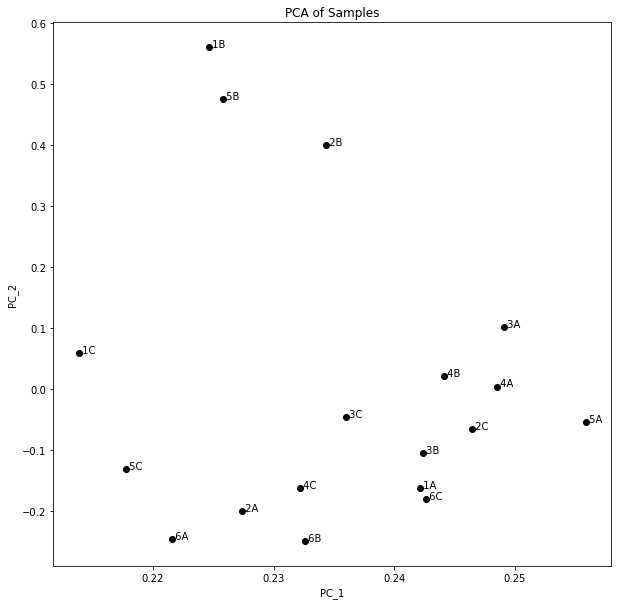

In [108]:
#Do a PCA of each Sample
from sklearn.decomposition import PCA

cols = []
for col in pg.columns:
    if 'LFQ intensity' in col:
        cols.append(col)

data = pg[cols]

pca = PCA(n_components=2)
pca.fit(data)

plt.figure(figsize=(10,10))

for coln in range(len(cols)):
    sample = cols[coln].split('LFQ intensity')[1]
    plt.scatter(pca.components_[0,coln],pca.components_[1,coln],c='black')
    plt.annotate(sample,(pca.components_[0,coln],pca.components_[1,coln]))
    
plt.title('PCA of Samples')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.savefig('Samples_pca.png')

In [109]:
def create_row(row,control_index,experiments):
    '''
        Creates a row for summary data output. 
    '''
    columns_keep = ['Protein IDs','Protein names','Gene names','Q-value']
    for condition in experiments:
        for replicate in condition:
            columns_keep.append('LFQ intensity ' + replicate)
    
    row = row[columns_keep]
    
    #Get the log fold change for each condition relative to the control
    for c in range(len(experiments)):
        if c != control_index:
            control_mean = np.mean([row['LFQ intensity ' + rep] for rep in experiments[control_index]])
            condition_mean = np.mean([row['LFQ intensity ' + rep] for rep in experiments[c]])
            #print(str(condition_mean) + ' , ' + str(control_mean))
            row['logFC_' + ','.join(experiments[c]) + '_vs_' + ','.join(experiments[control_index])] = log((condition_mean + 1)/(control_mean + 1),2)
            
            # Now get the pvalue
            ttest = ttest_ind([row['LFQ intensity ' + rep] for rep in experiments[control_index]],[row['LFQ intensity ' + rep] for rep in experiments[c]])
            row['pval_' + ','.join(experiments[c]) + '_vs_' + ','.join(experiments[control_index])] = ttest[1]
            
    return row
    

In [111]:
out_data = pg.apply(create_row,axis=1,args=([3,experiments]))
# Do an FDR correction on the pvals
for colname in out_data.columns:
    if 'pval' in colname:
        out_data[colname + '_corrected'] = multipletests(out_data[colname],method='fdr_bh')[1]
#         print(out_data[colname])

In [112]:
out_data.to_csv('control_4_analysis.csv')

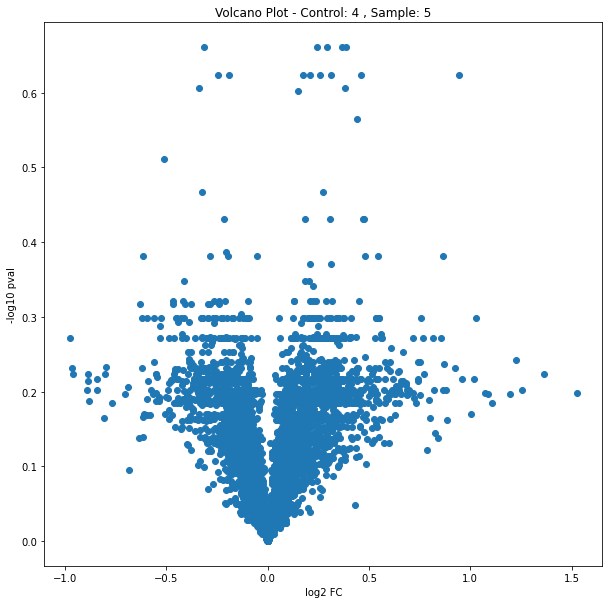

In [114]:
# Create a volcano plot

# Filter rows where the protein has zero intensity in either the control or test


plt.figure(figsize=(10,10))
plt.scatter(out_data['logFC_5A,5B,5C_vs_4A,4B,4C'],out_data['pval_5A,5B,5C_vs_4A,4B,4C_corrected'].apply(log,args=([10])).apply(lambda x: -1*x)) # Change the column
plt.xlabel('log2 FC')
plt.ylabel('-log10 pval')
plt.title('Volcano Plot - Control: 4 , Sample: 5')
plt.savefig('volcano_5_vs_4.png')
#plt.xlim([-5,5])